## Assessing Balance in Matching

To assess covariate balance before and after matching, hypothesis tests such as t-tests and p-values are used to compare the means of covariates between treated and control groups. 

In [28]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from sklearn.metrics import pairwise_distances

In [18]:
data = pd.read_csv('../rhc.csv')
data.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [31]:
# treatment (1 = treated, 0 = control)
data['treatment'] = data['ca'].apply(lambda x: 1 if x == 'Yes' else 0)

# outcome (1 = death, 0 = survival)
data['outcome'] = data['death'].apply(lambda x: 1 if x == 'Yes' else 0)

# relevant covariates
covariates = ['age', 'income', 'cardiohx', 'renalhx', 'meanbp1']

In [32]:
data.columns 

Index(['Unnamed: 0', 'cat1', 'cat2', 'ca', 'sadmdte', 'dschdte', 'dthdte',
       'lstctdte', 'death', 'cardiohx', 'chfhx', 'dementhx', 'psychhx',
       'chrpulhx', 'renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx',
       'transhx', 'amihx', 'age', 'sex', 'edu', 'surv2md1', 'das2d3pc',
       't3d30', 'dth30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1',
       'temp1', 'pafi1', 'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1',
       'paco21', 'ph1', 'swang1', 'wtkilo1', 'dnr1', 'ninsclas', 'resp',
       'card', 'neuro', 'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma',
       'ortho', 'adld3p', 'urin1', 'race', 'income', 'ptid', 'treatment',
       'outcome', 'propensity_score'],
      dtype='object')

In [56]:
from sklearn.linear_model import LogisticRegression

# One-hot encode categorical covariates (income)
data_encoded = pd.get_dummies(data, columns=['income'], drop_first=True)

# propensity scores
covariates_encoded = ['age', 'cardiohx', 'renalhx', 'meanbp1']
log_reg = LogisticRegression()
data['propensity_score'] = log_reg.fit(data_encoded[covariates_encoded], data['treatment']).predict_proba(data_encoded[covariates_encoded])[:, 1]

In [57]:
treated = data[data['treatment'] == 1]
control = data[data['treatment'] == 0]

# nearest neighbor (propensity scores)
distances = pairwise_distances(treated[['propensity_score']], control[['propensity_score']], metric='euclidean')
matched_idx = distances.argmin(axis=1)

# matched dataset
matched_control = control.iloc[matched_idx].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)
matched_data = pd.concat([matched_treated, matched_control])

### p-values in balance testing (t-test)

p-value indicates the probability of observing the data if null-hypothesis is true. 

t-statistic measures how many standard deviations the group means are apart, and the p-value tests the hypothesis that the means are equal. 

Before matching: `t-stat=large`, `p-value=small`, since the treated and control groups are **highly imbalanced**.

In [58]:
def assess_balance(group1, group2, covariates):
    results = {}
    for cov in covariates:
        print(cov)
        t_stat, p_value = ttest_ind(group1[cov], group2[cov], equal_var=False)
        results[cov] = {'t_statistic':t_stat, 'p-value':p_value}
    return results 

In [59]:
balance_before = assess_balance(treated, control, covariates_encoded)
balance_before

age
cardiohx
renalhx
meanbp1


{'age': {'t_statistic': 4.361701112609548, 'p-value': 1.3838741831022063e-05},
 'cardiohx': {'t_statistic': -6.814632856852341,
  'p-value': 1.3199182720903228e-11},
 'renalhx': {'t_statistic': -4.325844884523025,
  'p-value': 1.5998721445567795e-05},
 'meanbp1': {'t_statistic': -4.722520774359171,
  'p-value': 2.550256630427816e-06}}

In [60]:
balance_after = assess_balance(matched_treated, matched_control, covariates_encoded)
balance_after

age
cardiohx
renalhx
meanbp1


{'age': {'t_statistic': 0.9384728693982591, 'p-value': 0.3481182085059026},
 'cardiohx': {'t_statistic': 1.3497272325367844,
  'p-value': 0.17726182500479318},
 'renalhx': {'t_statistic': -0.5728571074140258,
  'p-value': 0.5668081691246154},
 'meanbp1': {'t_statistic': -0.4552028528128653,
  'p-value': 0.6490143011365392}}

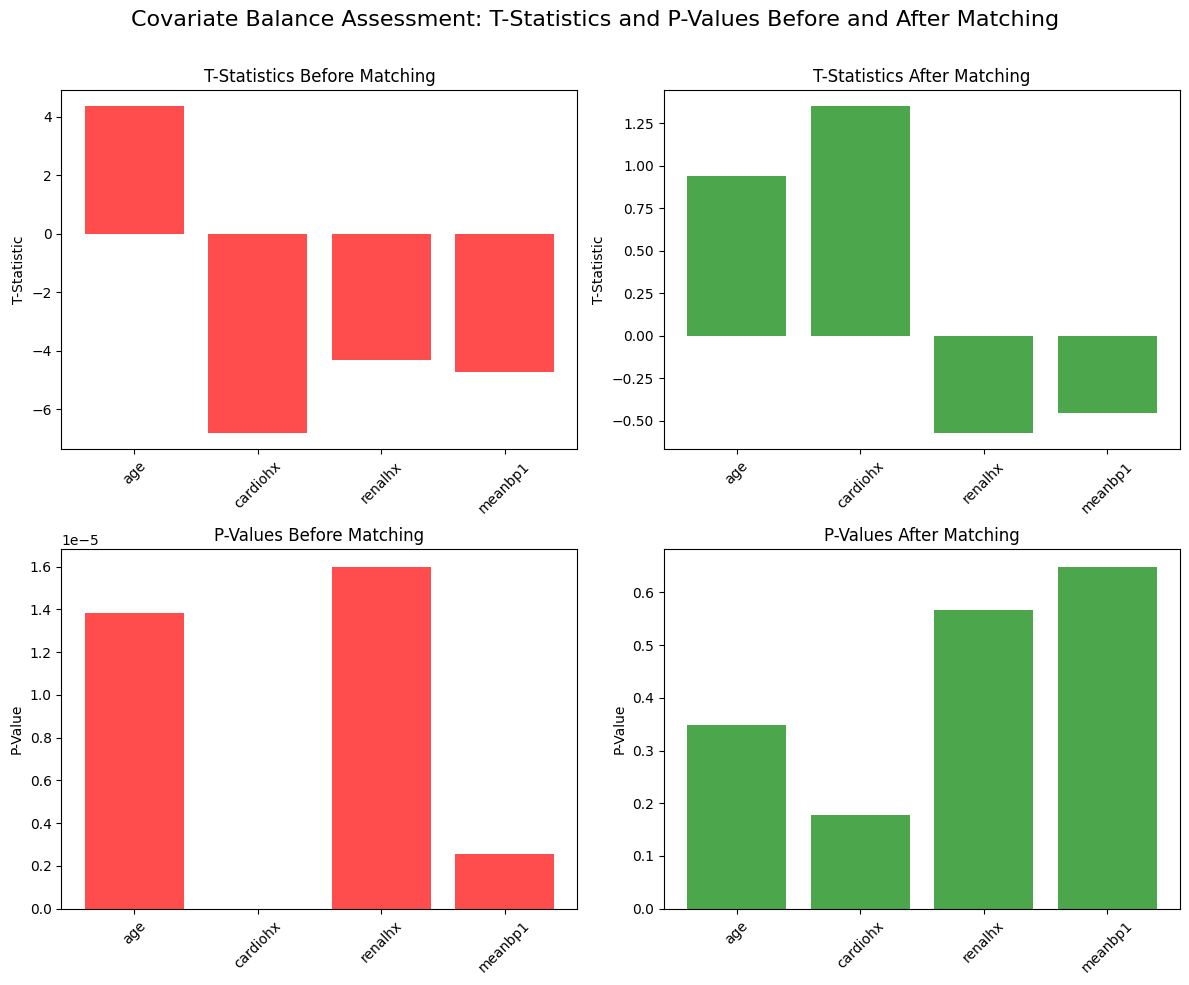

In [62]:
import matplotlib.pyplot as plt

# Visualize p-values before and after matching
before_pvals = [v['p-value'] for v in balance_before.values()]
after_pvals = [v['p-value'] for v in balance_after.values()]

before_t_stat = [v['t_statistic'] for v in balance_before.values()]
after_t_stat = [v['t_statistic'] for v in balance_after.values()]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot for t-statistics before and after matching
axes[0, 0].bar(covariates_encoded, before_t_stat, color='red', alpha=0.7, label='Before Matching')
axes[0, 0].set_title('T-Statistics Before Matching')
axes[0, 0].set_ylabel('T-Statistic')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(covariates_encoded, after_t_stat, color='green', alpha=0.7, label='After Matching')
axes[0, 1].set_title('T-Statistics After Matching')
axes[0, 1].set_ylabel('T-Statistic')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot for p-values before and after matching
axes[1, 0].bar(covariates_encoded, before_pvals, color='red', alpha=0.7, label='Before Matching')
axes[1, 0].set_title('P-Values Before Matching')
axes[1, 0].set_ylabel('P-Value')
# axes[1, 0].axhline(0.05, color='blue', linestyle='--', label='Significance Threshold')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(covariates_encoded, after_pvals, color='green', alpha=0.7, label='After Matching')
axes[1, 1].set_title('P-Values After Matching')
axes[1, 1].set_ylabel('P-Value')
# axes[1, 1].axhline(0.05, color='blue', linestyle='--', label='Significance Threshold')
axes[1, 1].tick_params(axis='x', rotation=45)

# Set overall title and show the plot
fig.suptitle('Covariate Balance Assessment: T-Statistics and P-Values Before and After Matching', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the title to prevent overlap
plt.show()


Here, we can assess the balance of matching by p-value and t-statistic. The increment of p-value denotes that the means of treatment and control group means are close to zero, whereas decrement of t-statistic after matching denotes that the group means are **less** Standard Deviations away from each other. 